In [1]:
import os
import tensorflow.keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = tensorflow.keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = tensorflow.keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from tensorflow.keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = tensorflow.keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = tensorflow.keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = tensorflow.keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = tensorflow.keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = tensorflow.keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
"""
# 載入 Callbacks, 並設定監控目標為 validation loss
"""
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)

In [8]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = tensorflow.keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[reduce_lr]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512   

Epoch 42/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.7953 - accuracy: 0.7470 - val_loss: 1.4796 - val_accuracy: 0.5024
Epoch 43/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.7931 - accuracy: 0.7475 - val_loss: 1.4802 - val_accuracy: 0.5007
Epoch 44/50
50000/50000 [==============================] - 1s 21us/sample - loss: 0.7907 - accuracy: 0.7483 - val_loss: 1.4800 - val_accuracy: 0.5050
Epoch 45/50
50000/50000 [==============================] - 1s 21us/sample - loss: 0.7887 - accuracy: 0.7492 - val_loss: 1.4805 - val_accuracy: 0.5040
Epoch 46/50
47104/50000 [===========================>..] - ETA: 0s - loss: 0.7879 - accuracy: 0.7499
Epoch 00046: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
50000/50000 [==============================] - 1s 23us/sample - loss: 0.7871 - accuracy: 0.7497 - val_loss: 1.4824 - val_accuracy: 0.5037
Epoch 47/50
50000/50000 [==============================] - 1s 24us/sample - loss:

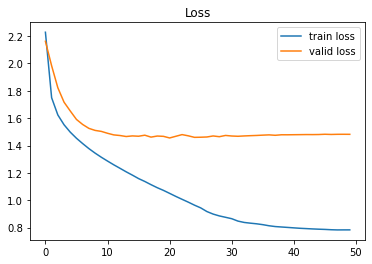

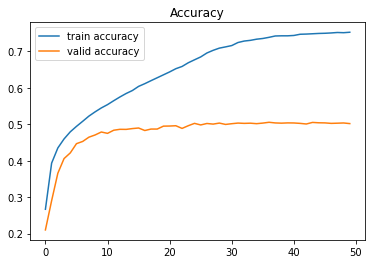

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

## Work

請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響

請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [12]:
"""
建立實驗組合
"""
optimizer_set = [tensorflow.keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 tensorflow.keras.optimizers.Adam(lr=LEARNING_RATE),
                 tensorflow.keras.optimizers.RMSprop(lr=LEARNING_RATE)]
reduce_lr_factor = [0.99, 0.5, 0.1]
redice_lr_patient = [3,5,10]

In [13]:
"""
以迴圈方式遍歷組合來訓練模型
"""
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.99, reduce_patient: 3
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

Epoch 39/50
50000/50000 [==============================] - 1s 21us/sample - loss: 0.6848 - accuracy: 0.7858 - val_loss: 1.5554 - val_accuracy: 0.4927
Epoch 40/50
50000/50000 [==============================] - 1s 21us/sample - loss: 0.6678 - accuracy: 0.7923 - val_loss: 1.5574 - val_accuracy: 0.4952
Epoch 41/50
48128/50000 [===========================>..] - ETA: 0s - loss: 0.6491 - accuracy: 0.7998
Epoch 00041: ReduceLROnPlateau reducing learning rate to 0.0009320654743351042.
50000/50000 [==============================] - 1s 22us/sample - loss: 0.6494 - accuracy: 0.7996 - val_loss: 1.5788 - val_accuracy: 0.4897
Epoch 42/50
50000/50000 [==============================] - 1s 21us/sample - loss: 0.6344 - accuracy: 0.8063 - val_loss: 1.6001 - val_accuracy: 0.4951
Epoch 43/50
50000/50000 [==============================] - 1s 19us/sample - loss: 0.6190 - accuracy: 0.8115 - val_loss: 1.5868 - val_accuracy: 0.4939
Epoch 44/50
48128/50000 [===========================>..] - ETA: 0s - loss: 0.5998

50000/50000 [==============================] - 1s 19us/sample - loss: 0.9509 - accuracy: 0.6818 - val_loss: 1.4618 - val_accuracy: 0.4938
Epoch 28/50
50000/50000 [==============================] - ETA: 0s - loss: 0.9315 - accuracy: 0.68 - 1s 20us/sample - loss: 0.9314 - accuracy: 0.6884 - val_loss: 1.4712 - val_accuracy: 0.4927
Epoch 29/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.9115 - accuracy: 0.6957 - val_loss: 1.4728 - val_accuracy: 0.4927
Epoch 30/50
46080/50000 [==========================>...] - ETA: 0s - loss: 0.8955 - accuracy: 0.7010
Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.000886384982150048.
50000/50000 [==============================] - 1s 20us/sample - loss: 0.8948 - accuracy: 0.7011 - val_loss: 1.4732 - val_accuracy: 0.4959
Epoch 31/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.8759 - accuracy: 0.7100 - val_loss: 1.4850 - val_accuracy: 0.4934
Epoch 32/50
50000/50000 [===========================

50000/50000 [==============================] - 1s 19us/sample - loss: 1.2325 - accuracy: 0.5746 - val_loss: 1.4849 - val_accuracy: 0.4813
Epoch 16/50
50000/50000 [==============================] - 1s 20us/sample - loss: 1.2104 - accuracy: 0.5841 - val_loss: 1.4893 - val_accuracy: 0.4793
Epoch 17/50
50000/50000 [==============================] - 1s 20us/sample - loss: 1.1904 - accuracy: 0.5913 - val_loss: 1.4822 - val_accuracy: 0.4822
Epoch 18/50
50000/50000 [==============================] - 1s 20us/sample - loss: 1.1697 - accuracy: 0.5977 - val_loss: 1.4706 - val_accuracy: 0.4825
Epoch 19/50
50000/50000 [==============================] - 1s 19us/sample - loss: 1.1493 - accuracy: 0.6068 - val_loss: 1.4749 - val_accuracy: 0.4866
Epoch 20/50
50000/50000 [==============================] - 1s 20us/sample - loss: 1.1297 - accuracy: 0.6150 - val_loss: 1.4749 - val_accuracy: 0.4847
Epoch 21/50
50000/50000 [==============================] - 1s 20us/sample - loss: 1.1088 - accuracy: 0.6215 - va

50000/50000 [==============================] - 1s 20us/sample - loss: 1.4396 - accuracy: 0.5005 - val_loss: 1.5877 - val_accuracy: 0.4441
Epoch 8/50
50000/50000 [==============================] - 1s 19us/sample - loss: 1.4054 - accuracy: 0.5133 - val_loss: 1.5461 - val_accuracy: 0.4606
Epoch 9/50
50000/50000 [==============================] - 1s 19us/sample - loss: 1.3737 - accuracy: 0.5233 - val_loss: 1.5236 - val_accuracy: 0.4605
Epoch 10/50
50000/50000 [==============================] - 1s 20us/sample - loss: 1.3439 - accuracy: 0.5328 - val_loss: 1.5121 - val_accuracy: 0.4674
Epoch 11/50
50000/50000 [==============================] - 1s 19us/sample - loss: 1.3178 - accuracy: 0.5437 - val_loss: 1.4990 - val_accuracy: 0.4714
Epoch 12/50
50000/50000 [==============================] - 1s 20us/sample - loss: 1.2910 - accuracy: 0.5528 - val_loss: 1.4914 - val_accuracy: 0.4733
Epoch 13/50
50000/50000 [==============================] - 1s 19us/sample - loss: 1.2667 - accuracy: 0.5620 - val_

Epoch 50/50
50000/50000 [==============================] - 1s 19us/sample - loss: 1.0298 - accuracy: 0.6558 - val_loss: 1.4615 - val_accuracy: 0.4899
Numbers of exp: 4, reduce_factor: 0.50, reduce_patient: 5
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_15 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________

Epoch 37/50
50000/50000 [==============================] - 1s 19us/sample - loss: 2.9164 - accuracy: 0.1119 - val_loss: 2.9331 - val_accuracy: 0.1067
Epoch 38/50
50000/50000 [==============================] - 1s 19us/sample - loss: 2.9169 - accuracy: 0.1111 - val_loss: 2.9330 - val_accuracy: 0.1070
Epoch 39/50
50000/50000 [==============================] - 1s 20us/sample - loss: 2.9164 - accuracy: 0.1111 - val_loss: 2.9329 - val_accuracy: 0.1068
Epoch 40/50
50000/50000 [==============================] - 1s 20us/sample - loss: 2.9165 - accuracy: 0.1113 - val_loss: 2.9329 - val_accuracy: 0.1067
Epoch 41/50
46080/50000 [==========================>...] - ETA: 0s - loss: 2.9166 - accuracy: 0.1112 ETA: 0s - loss: 2.9084 - accu
Epoch 00041: ReduceLROnPlateau reducing learning rate to 3.183417751628781e-09.
50000/50000 [==============================] - 1s 19us/sample - loss: 2.9168 - accuracy: 0.1107 - val_loss: 2.9327 - val_accuracy: 0.1071
Epoch 42/50
50000/50000 [==========================

Epoch 27/50
50000/50000 [==============================] - 1s 20us/sample - loss: 3.0899 - accuracy: 0.0900 - val_loss: 3.1151 - val_accuracy: 0.0872
Epoch 28/50
50000/50000 [==============================] - 1s 20us/sample - loss: 3.0911 - accuracy: 0.0907 - val_loss: 3.1150 - val_accuracy: 0.0872
Epoch 29/50
50000/50000 [==============================] - 1s 19us/sample - loss: 3.0913 - accuracy: 0.0901 - val_loss: 3.1153 - val_accuracy: 0.0872
Epoch 30/50
50000/50000 [==============================] - 1s 19us/sample - loss: 3.0904 - accuracy: 0.0907 - val_loss: 3.1154 - val_accuracy: 0.0872
Epoch 31/50
48128/50000 [===========================>..] - ETA: 0s - loss: 3.0913 - accuracy: 0.0908
Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.989636094767988e-10.
50000/50000 [==============================] - 1s 19us/sample - loss: 3.0912 - accuracy: 0.0907 - val_loss: 3.1152 - val_accuracy: 0.0872
Epoch 32/50
50000/50000 [==============================] - 1s 20us/sample - loss:

Epoch 17/50
50000/50000 [==============================] - 1s 19us/sample - loss: 2.9630 - accuracy: 0.1112 - val_loss: 2.9363 - val_accuracy: 0.1147
Epoch 18/50
50000/50000 [==============================] - 1s 19us/sample - loss: 2.9618 - accuracy: 0.1111 - val_loss: 2.9405 - val_accuracy: 0.1148
Epoch 19/50
50000/50000 [==============================] - 1s 19us/sample - loss: 2.9614 - accuracy: 0.1111 - val_loss: 2.9433 - val_accuracy: 0.1150
Epoch 20/50
50000/50000 [==============================] - 1s 20us/sample - loss: 2.9622 - accuracy: 0.1117 - val_loss: 2.9451 - val_accuracy: 0.1150
Epoch 21/50
50000/50000 [==============================] - 1s 19us/sample - loss: 2.9627 - accuracy: 0.1117 - val_loss: 2.9462 - val_accuracy: 0.1152
Epoch 22/50
50000/50000 [==============================] - 1s 20us/sample - loss: 2.9619 - accuracy: 0.1116 - val_loss: 2.9469 - val_accuracy: 0.1149
Epoch 23/50
50000/50000 [==============================] - 1s 20us/sample - loss: 2.9620 - accuracy:

50000/50000 [==============================] - 1s 20us/sample - loss: 3.1358 - accuracy: 0.0931 - val_loss: 3.0028 - val_accuracy: 0.0916
Epoch 12/50
50000/50000 [==============================] - 1s 20us/sample - loss: 3.1355 - accuracy: 0.0928 - val_loss: 3.0392 - val_accuracy: 0.0907
Epoch 13/50
50000/50000 [==============================] - 1s 21us/sample - loss: 3.1358 - accuracy: 0.0926 - val_loss: 3.0682 - val_accuracy: 0.0900
Epoch 14/50
50000/50000 [==============================] - 1s 20us/sample - loss: 3.1352 - accuracy: 0.0929 - val_loss: 3.0904 - val_accuracy: 0.0899
Epoch 15/50
50000/50000 [==============================] - 1s 20us/sample - loss: 3.1371 - accuracy: 0.0923 - val_loss: 3.1066 - val_accuracy: 0.0904
Epoch 16/50
50000/50000 [==============================] - 1s 20us/sample - loss: 3.1361 - accuracy: 0.0923 - val_loss: 3.1178 - val_accuracy: 0.0906
Epoch 17/50
50000/50000 [==============================] - 1s 20us/sample - loss: 3.1359 - accuracy: 0.0931 - va

Epoch 5/50
50000/50000 [==============================] - 1s 19us/sample - loss: 2.9056 - accuracy: 0.1061 - val_loss: 2.4970 - val_accuracy: 0.1093
Epoch 6/50
50000/50000 [==============================] - 1s 20us/sample - loss: 2.9062 - accuracy: 0.1075 - val_loss: 2.5528 - val_accuracy: 0.1090
Epoch 7/50
50000/50000 [==============================] - 1s 19us/sample - loss: 2.9056 - accuracy: 0.1087 - val_loss: 2.6073 - val_accuracy: 0.1080
Epoch 8/50
50000/50000 [==============================] - 1s 19us/sample - loss: 2.9065 - accuracy: 0.1073 - val_loss: 2.6581 - val_accuracy: 0.1071
Epoch 9/50
50000/50000 [==============================] - 1s 20us/sample - loss: 2.9058 - accuracy: 0.1065 - val_loss: 2.7035 - val_accuracy: 0.1074
Epoch 10/50
50000/50000 [==============================] - 1s 20us/sample - loss: 2.9063 - accuracy: 0.1072 - val_loss: 2.7429 - val_accuracy: 0.1075
Epoch 11/50
50000/50000 [==============================] - 1s 21us/sample - loss: 2.9051 - accuracy: 0.10

50000/50000 [==============================] - 2s 42us/sample - loss: 1.7866 - accuracy: 0.3811 - val_loss: 2.3578 - val_accuracy: 0.2401
Epoch 2/50
50000/50000 [==============================] - 1s 19us/sample - loss: 1.5126 - accuracy: 0.4690 - val_loss: 1.9382 - val_accuracy: 0.3121
Epoch 3/50
50000/50000 [==============================] - 1s 19us/sample - loss: 1.4022 - accuracy: 0.5046 - val_loss: 1.7905 - val_accuracy: 0.3707
Epoch 4/50
50000/50000 [==============================] - 1s 20us/sample - loss: 1.3247 - accuracy: 0.5345 - val_loss: 2.1499 - val_accuracy: 0.3113
Epoch 5/50
50000/50000 [==============================] - 1s 20us/sample - loss: 1.2641 - accuracy: 0.5548 - val_loss: 1.8953 - val_accuracy: 0.3461
Epoch 6/50
49152/50000 [============================>.] - ETA: 0s - loss: 1.2050 - accuracy: 0.5753 ETA: 0s - loss: 1.1962 - ac
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0009900000470224768.
50000/50000 [==============================] - 1s 19us/sam

Epoch 41/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.1612 - accuracy: 0.9533 - val_loss: 2.7212 - val_accuracy: 0.4650
Epoch 42/50
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1410 - accuracy: 0.9605 - val_loss: 2.7861 - val_accuracy: 0.4476
Epoch 43/50
49152/50000 [============================>.] - ETA: 0s - loss: 0.1392 - accuracy: 0.9602
Epoch 00043: ReduceLROnPlateau reducing learning rate to 0.0008775211300235242.
50000/50000 [==============================] - 1s 20us/sample - loss: 0.1399 - accuracy: 0.9599 - val_loss: 2.6798 - val_accuracy: 0.4740
Epoch 44/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.1258 - accuracy: 0.9645 - val_loss: 2.7710 - val_accuracy: 0.4768
Epoch 45/50
50000/50000 [==============================] - 1s 22us/sample - loss: 0.1146 - accuracy: 0.9690 - val_loss: 3.0719 - val_accuracy: 0.4421
Epoch 46/50
47104/50000 [===========================>..] - ETA: 0s - loss: 0.1013

Epoch 30/50
50000/50000 [==============================] - 1s 19us/sample - loss: 0.4966 - accuracy: 0.8307 - val_loss: 1.9869 - val_accuracy: 0.4733
Epoch 31/50
48128/50000 [===========================>..] - ETA: 0s - loss: 0.4559 - accuracy: 0.8449
Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.0008345138886943459.
50000/50000 [==============================] - 1s 19us/sample - loss: 0.4569 - accuracy: 0.8442 - val_loss: 2.0506 - val_accuracy: 0.4706
Epoch 32/50
50000/50000 [==============================] - 1s 19us/sample - loss: 0.4288 - accuracy: 0.8557 - val_loss: 2.0781 - val_accuracy: 0.4836
Epoch 33/50
50000/50000 [==============================] - 1s 19us/sample - loss: 0.4143 - accuracy: 0.8597 - val_loss: 2.0177 - val_accuracy: 0.4805
Epoch 34/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.3859 - accuracy: 0.8723 - val_loss: 2.2550 - val_accuracy: 0.4776
Epoch 35/50
50000/50000 [==============================] - 1s 20us/sample - loss:

50000/50000 [==============================] - 1s 20us/sample - loss: 0.8838 - accuracy: 0.6880 - val_loss: 1.6837 - val_accuracy: 0.4689
Epoch 19/50
50000/50000 [==============================] - 1s 23us/sample - loss: 0.8623 - accuracy: 0.6962 - val_loss: 1.4865 - val_accuracy: 0.5008s - loss: 0.8602 - accuracy: 0.
Epoch 20/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.8298 - accuracy: 0.7068 - val_loss: 1.5202 - val_accuracy: 0.4975
Epoch 21/50
50000/50000 [==============================] - 1s 19us/sample - loss: 0.7999 - accuracy: 0.7172 - val_loss: 1.6135 - val_accuracy: 0.4841
Epoch 22/50
50000/50000 [==============================] - 1s 19us/sample - loss: 0.7693 - accuracy: 0.7279 - val_loss: 1.6070 - val_accuracy: 0.4886
Epoch 23/50
50000/50000 [==============================] - 1s 19us/sample - loss: 0.7362 - accuracy: 0.7403 - val_loss: 1.6029 - val_accuracy: 0.4890
Epoch 24/50
50000/50000 [==============================] - 1s 22us/sample - loss:

50000/50000 [==============================] - 1s 21us/sample - loss: 1.2142 - accuracy: 0.5688 - val_loss: 1.5426 - val_accuracy: 0.4589
Epoch 9/50
50000/50000 [==============================] - 1s 21us/sample - loss: 1.1750 - accuracy: 0.5842 - val_loss: 1.4370 - val_accuracy: 0.4880
Epoch 10/50
50000/50000 [==============================] - 1s 20us/sample - loss: 1.1380 - accuracy: 0.5960 - val_loss: 1.4350 - val_accuracy: 0.4873
Epoch 11/50
50000/50000 [==============================] - ETA: 0s - loss: 1.1004 - accuracy: 0.60 - 1s 21us/sample - loss: 1.1002 - accuracy: 0.6100 - val_loss: 1.5079 - val_accuracy: 0.4773
Epoch 12/50
50000/50000 [==============================] - 1s 23us/sample - loss: 1.0747 - accuracy: 0.6197 - val_loss: 1.6229 - val_accuracy: 0.4487
Epoch 13/50
46080/50000 [==========================>...] - ETA: 0s - loss: 1.0361 - accuracy: 0.6335
Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.000388910761103034.
50000/50000 [============================

Epoch 49/50
50000/50000 [==============================] - 1s 19us/sample - loss: 0.6805 - accuracy: 0.7722 - val_loss: 1.3979 - val_accuracy: 0.5445
Epoch 50/50
50000/50000 [==============================] - 1s 19us/sample - loss: 0.6813 - accuracy: 0.7718 - val_loss: 1.3979 - val_accuracy: 0.5446
Numbers of exp: 13, reduce_factor: 0.50, reduce_patient: 5
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_42 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_____________________________

48128/50000 [===========================>..] - ETA: 0s - loss: 2.5242 - accuracy: 0.1858
Epoch 00036: ReduceLROnPlateau reducing learning rate to 1.4835768169518815e-09.
50000/50000 [==============================] - 1s 20us/sample - loss: 2.5249 - accuracy: 0.1857 - val_loss: 2.5150 - val_accuracy: 0.1894
Epoch 37/50
50000/50000 [==============================] - 1s 21us/sample - loss: 2.5242 - accuracy: 0.1850 - val_loss: 2.5147 - val_accuracy: 0.1897
Epoch 38/50
50000/50000 [==============================] - 1s 21us/sample - loss: 2.5249 - accuracy: 0.1852 - val_loss: 2.5146 - val_accuracy: 0.1896
Epoch 39/50
50000/50000 [==============================] - 1s 20us/sample - loss: 2.5246 - accuracy: 0.1857 - val_loss: 2.5146 - val_accuracy: 0.1896
Epoch 40/50
50000/50000 [==============================] - 1s 20us/sample - loss: 2.5253 - accuracy: 0.1843 - val_loss: 2.5146 - val_accuracy: 0.1897
Epoch 41/50
49152/50000 [============================>.] - ETA: 0s - loss: 2.5242 - accuracy

Epoch 25/50
50000/50000 [==============================] - 1s 19us/sample - loss: 3.1169 - accuracy: 0.0892 - val_loss: 3.1293 - val_accuracy: 0.0855
Epoch 26/50
50000/50000 [==============================] - 1s 19us/sample - loss: 3.1157 - accuracy: 0.0879 - val_loss: 3.1293 - val_accuracy: 0.0854
Epoch 27/50
50000/50000 [==============================] - 1s 20us/sample - loss: 3.1171 - accuracy: 0.0880 - val_loss: 3.1296 - val_accuracy: 0.0857
Epoch 28/50
50000/50000 [==============================] - 1s 20us/sample - loss: 3.1174 - accuracy: 0.0887 - val_loss: 3.1296 - val_accuracy: 0.0855
Epoch 29/50
50000/50000 [==============================] - 1s 19us/sample - loss: 3.1170 - accuracy: 0.0888 - val_loss: 3.1297 - val_accuracy: 0.0855
Epoch 30/50
50000/50000 [==============================] - 1s 20us/sample - loss: 3.1163 - accuracy: 0.0877 - val_loss: 3.1297 - val_accuracy: 0.0854
Epoch 31/50
49152/50000 [============================>.] - ETA: 0s - loss: 3.1151 - accuracy: 0.0893

50000/50000 [==============================] - 1s 20us/sample - loss: 2.9769 - accuracy: 0.1157 - val_loss: 2.9504 - val_accuracy: 0.1146
Epoch 16/50
50000/50000 [==============================] - 1s 20us/sample - loss: 2.9763 - accuracy: 0.1162 - val_loss: 2.9627 - val_accuracy: 0.1144
Epoch 17/50
50000/50000 [==============================] - 1s 20us/sample - loss: 2.9760 - accuracy: 0.1164 - val_loss: 2.9711 - val_accuracy: 0.1147
Epoch 18/50
50000/50000 [==============================] - 1s 19us/sample - loss: 2.9745 - accuracy: 0.1154 - val_loss: 2.9766 - val_accuracy: 0.1140
Epoch 19/50
50000/50000 [==============================] - 1s 19us/sample - loss: 2.9759 - accuracy: 0.1171 - val_loss: 2.9800 - val_accuracy: 0.1138
Epoch 20/50
50000/50000 [==============================] - 1s 20us/sample - loss: 2.9746 - accuracy: 0.1173 - val_loss: 2.9822 - val_accuracy: 0.1136
Epoch 21/50
50000/50000 [==============================] - 1s 20us/sample - loss: 2.9755 - accuracy: 0.1160 - va

50000/50000 [==============================] - 1s 20us/sample - loss: 3.0711 - accuracy: 0.0938 - val_loss: 2.8706 - val_accuracy: 0.0882
Epoch 10/50
50000/50000 [==============================] - 1s 20us/sample - loss: 3.0720 - accuracy: 0.0940 - val_loss: 2.9157 - val_accuracy: 0.0888
Epoch 11/50
50000/50000 [==============================] - 1s 19us/sample - loss: 3.0726 - accuracy: 0.0925 - val_loss: 2.9552 - val_accuracy: 0.0895
Epoch 12/50
50000/50000 [==============================] - 1s 20us/sample - loss: 3.0720 - accuracy: 0.0936 - val_loss: 2.9882 - val_accuracy: 0.0880
Epoch 13/50
50000/50000 [==============================] - 1s 20us/sample - loss: 3.0717 - accuracy: 0.0940 - val_loss: 3.0147 - val_accuracy: 0.0894
Epoch 14/50
50000/50000 [==============================] - 1s 20us/sample - loss: 3.0720 - accuracy: 0.0938 - val_loss: 3.0349 - val_accuracy: 0.0894
Epoch 15/50
50000/50000 [==============================] - 1s 20us/sample - loss: 3.0723 - accuracy: 0.0937 - va

50000/50000 [==============================] - 1s 21us/sample - loss: 2.9813 - accuracy: 0.0983 - val_loss: 2.4613 - val_accuracy: 0.0941
Epoch 4/50
50000/50000 [==============================] - 1s 20us/sample - loss: 2.9818 - accuracy: 0.0980 - val_loss: 2.5156 - val_accuracy: 0.0884
Epoch 5/50
50000/50000 [==============================] - 1s 20us/sample - loss: 2.9820 - accuracy: 0.0985 - val_loss: 2.5719 - val_accuracy: 0.0872
Epoch 6/50
50000/50000 [==============================] - 1s 20us/sample - loss: 2.9810 - accuracy: 0.0984 - val_loss: 2.6299 - val_accuracy: 0.0877
Epoch 7/50
50000/50000 [==============================] - 1s 20us/sample - loss: 2.9808 - accuracy: 0.0979 - val_loss: 2.6875 - val_accuracy: 0.0887
Epoch 8/50
50000/50000 [==============================] - 1s 20us/sample - loss: 2.9812 - accuracy: 0.0987 - val_loss: 2.7421 - val_accuracy: 0.0890
Epoch 9/50
50000/50000 [==============================] - 1s 20us/sample - loss: 2.9820 - accuracy: 0.0979 - val_loss

50000/50000 [==============================] - 2s 43us/sample - loss: 1.7951 - accuracy: 0.3750 - val_loss: 2.3000 - val_accuracy: 0.2076
Epoch 2/50
50000/50000 [==============================] - 1s 20us/sample - loss: 1.5276 - accuracy: 0.4581 - val_loss: 2.2831 - val_accuracy: 0.2768
Epoch 3/50
50000/50000 [==============================] - 1s 21us/sample - loss: 1.4257 - accuracy: 0.4970 - val_loss: 2.1046 - val_accuracy: 0.3027
Epoch 4/50
50000/50000 [==============================] - 1s 21us/sample - loss: 1.3571 - accuracy: 0.5210 - val_loss: 1.7334 - val_accuracy: 0.4040
Epoch 5/50
50000/50000 [==============================] - 1s 21us/sample - loss: 1.2909 - accuracy: 0.5468 - val_loss: 1.7259 - val_accuracy: 0.3887
Epoch 6/50
50000/50000 [==============================] - 1s 21us/sample - loss: 1.2374 - accuracy: 0.5619 - val_loss: 1.8214 - val_accuracy: 0.3596
Epoch 7/50
50000/50000 [==============================] - 1s 21us/sample - loss: 1.1958 - accuracy: 0.5792 - val_loss

Epoch 43/50
50000/50000 [==============================] - 1s 21us/sample - loss: 0.3162 - accuracy: 0.8946 - val_loss: 2.4267 - val_accuracy: 0.4692
Epoch 44/50
50000/50000 [==============================] - 1s 22us/sample - loss: 0.3013 - accuracy: 0.9006 - val_loss: 3.2148 - val_accuracy: 0.3772
Epoch 45/50
49152/50000 [============================>.] - ETA: 0s - loss: 0.2950 - accuracy: 0.9026
Epoch 00045: ReduceLROnPlateau reducing learning rate to 0.0008775211300235242.
50000/50000 [==============================] - 1s 24us/sample - loss: 0.2951 - accuracy: 0.9026 - val_loss: 2.4492 - val_accuracy: 0.4693
Epoch 46/50
50000/50000 [==============================] - 1s 24us/sample - loss: 0.2810 - accuracy: 0.9069 - val_loss: 2.7788 - val_accuracy: 0.4428
Epoch 47/50
50000/50000 [==============================] - 1s 24us/sample - loss: 0.2720 - accuracy: 0.9094 - val_loss: 2.7760 - val_accuracy: 0.4405
Epoch 48/50
47104/50000 [===========================>..] - ETA: 0s - loss: 0.2599

Epoch 31/50
47104/50000 [===========================>..] - ETA: 0s - loss: 0.5247 - accuracy: 0.8211
Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.0008261687244521454.
50000/50000 [==============================] - 1s 21us/sample - loss: 0.5241 - accuracy: 0.8213 - val_loss: 2.0269 - val_accuracy: 0.4446
Epoch 32/50
50000/50000 [==============================] - 1s 21us/sample - loss: 0.4979 - accuracy: 0.8325 - val_loss: 2.2684 - val_accuracy: 0.4352
Epoch 33/50
50000/50000 [==============================] - 1s 21us/sample - loss: 0.4839 - accuracy: 0.8349 - val_loss: 2.5336 - val_accuracy: 0.4069
Epoch 34/50
50000/50000 [==============================] - 1s 21us/sample - loss: 0.4640 - accuracy: 0.8428 - val_loss: 2.3016 - val_accuracy: 0.4134
Epoch 35/50
50000/50000 [==============================] - 1s 21us/sample - loss: 0.4497 - accuracy: 0.8478 - val_loss: 2.3531 - val_accuracy: 0.4371
Epoch 36/50
47104/50000 [===========================>..] - ETA: 0s - loss: 0.4263

50000/50000 [==============================] - 1s 21us/sample - loss: 0.8050 - accuracy: 0.7212 - val_loss: 1.8714 - val_accuracy: 0.4278
Epoch 20/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.7749 - accuracy: 0.7316 - val_loss: 1.6442 - val_accuracy: 0.4628
Epoch 21/50
50000/50000 [==============================] - 1s 21us/sample - loss: 0.7448 - accuracy: 0.7418 - val_loss: 2.0159 - val_accuracy: 0.4142
Epoch 22/50
50000/50000 [==============================] - 1s 21us/sample - loss: 0.7232 - accuracy: 0.7507 - val_loss: 1.9222 - val_accuracy: 0.4089
Epoch 23/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.7020 - accuracy: 0.7571 - val_loss: 2.1333 - val_accuracy: 0.4144
Epoch 24/50
50000/50000 [==============================] - 1s 21us/sample - loss: 0.6813 - accuracy: 0.7657 - val_loss: 1.9285 - val_accuracy: 0.4351
Epoch 25/50
50000/50000 [==============================] - 1s 21us/sample - loss: 0.6577 - accuracy: 0.7729 - va

50000/50000 [==============================] - 1s 20us/sample - loss: 1.0240 - accuracy: 0.6432 - val_loss: 1.6122 - val_accuracy: 0.4426
Epoch 10/50
50000/50000 [==============================] - 1s 21us/sample - loss: 0.9872 - accuracy: 0.6576 - val_loss: 1.5320 - val_accuracy: 0.4638
Epoch 11/50
50000/50000 [==============================] - 1s 21us/sample - loss: 0.9550 - accuracy: 0.6679 - val_loss: 1.5064 - val_accuracy: 0.4857
Epoch 12/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.9257 - accuracy: 0.6793 - val_loss: 1.4921 - val_accuracy: 0.4730
Epoch 13/50
50000/50000 [==============================] - 1s 21us/sample - loss: 0.8931 - accuracy: 0.6907 - val_loss: 1.5371 - val_accuracy: 0.4682
Epoch 14/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.8639 - accuracy: 0.7062 - val_loss: 1.4658 - val_accuracy: 0.4967
Epoch 15/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.8374 - accuracy: 0.7135 - va

Numbers of exp: 22, reduce_factor: 0.50, reduce_patient: 5
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_69 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_70 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________

50000/50000 [==============================] - 1s 20us/sample - loss: 2.7385 - accuracy: 0.1421 - val_loss: 2.7279 - val_accuracy: 0.1384
Epoch 38/50
50000/50000 [==============================] - 1s 20us/sample - loss: 2.7385 - accuracy: 0.1420 - val_loss: 2.7277 - val_accuracy: 0.1384
Epoch 39/50
50000/50000 [==============================] - 1s 21us/sample - loss: 2.7381 - accuracy: 0.1417 - val_loss: 2.7275 - val_accuracy: 0.1384
Epoch 40/50
50000/50000 [==============================] - 1s 21us/sample - loss: 2.7379 - accuracy: 0.1412 - val_loss: 2.7276 - val_accuracy: 0.1384
Epoch 41/50
47104/50000 [===========================>..] - ETA: 0s - loss: 2.7357 - accuracy: 0.1411
Epoch 00041: ReduceLROnPlateau reducing learning rate to 7.34370508848059e-10.
50000/50000 [==============================] - 1s 21us/sample - loss: 2.7376 - accuracy: 0.1410 - val_loss: 2.7274 - val_accuracy: 0.1383
Epoch 42/50
50000/50000 [==============================] - 1s 21us/sample - loss: 2.7378 - acc

50000/50000 [==============================] - 1s 20us/sample - loss: 2.9872 - accuracy: 0.0997 - val_loss: 3.0218 - val_accuracy: 0.0959
Epoch 27/50
50000/50000 [==============================] - 1s 21us/sample - loss: 2.9866 - accuracy: 0.1003 - val_loss: 3.0221 - val_accuracy: 0.0961
Epoch 28/50
50000/50000 [==============================] - 1s 20us/sample - loss: 2.9868 - accuracy: 0.0994 - val_loss: 3.0220 - val_accuracy: 0.0961
Epoch 29/50
50000/50000 [==============================] - 1s 20us/sample - loss: 2.9875 - accuracy: 0.0994 - val_loss: 3.0219 - val_accuracy: 0.0960
Epoch 30/50
50000/50000 [==============================] - 1s 21us/sample - loss: 2.9867 - accuracy: 0.0996 - val_loss: 3.0217 - val_accuracy: 0.0958
Epoch 31/50
47104/50000 [===========================>..] - ETA: 0s - loss: 2.9897 - accuracy: 0.1002
Epoch 00031: ReduceLROnPlateau reducing learning rate to 4.589815680300369e-11.
50000/50000 [==============================] - 1s 21us/sample - loss: 2.9870 - ac

50000/50000 [==============================] - 1s 20us/sample - loss: 2.9764 - accuracy: 0.1051 - val_loss: 2.9563 - val_accuracy: 0.1041
Epoch 16/50
50000/50000 [==============================] - 1s 20us/sample - loss: 2.9767 - accuracy: 0.1049 - val_loss: 2.9673 - val_accuracy: 0.1035
Epoch 17/50
50000/50000 [==============================] - 1s 21us/sample - loss: 2.9776 - accuracy: 0.1052 - val_loss: 2.9745 - val_accuracy: 0.1040
Epoch 18/50
50000/50000 [==============================] - 1s 21us/sample - loss: 2.9771 - accuracy: 0.1045 - val_loss: 2.9790 - val_accuracy: 0.1037
Epoch 19/50
50000/50000 [==============================] - 1s 21us/sample - loss: 2.9761 - accuracy: 0.1047 - val_loss: 2.9819 - val_accuracy: 0.1038
Epoch 20/50
50000/50000 [==============================] - 1s 21us/sample - loss: 2.9766 - accuracy: 0.1043 - val_loss: 2.9838 - val_accuracy: 0.1037
Epoch 21/50
50000/50000 [==============================] - 1s 21us/sample - loss: 2.9767 - accuracy: 0.1057 - va

50000/50000 [==============================] - 1s 20us/sample - loss: 2.9296 - accuracy: 0.1173 - val_loss: 2.6999 - val_accuracy: 0.1214
Epoch 10/50
50000/50000 [==============================] - 1s 21us/sample - loss: 2.9284 - accuracy: 0.1169 - val_loss: 2.7457 - val_accuracy: 0.1205
Epoch 11/50
50000/50000 [==============================] - 1s 21us/sample - loss: 2.9290 - accuracy: 0.1172 - val_loss: 2.7856 - val_accuracy: 0.1204
Epoch 12/50
50000/50000 [==============================] - 1s 22us/sample - loss: 2.9293 - accuracy: 0.1166 - val_loss: 2.8191 - val_accuracy: 0.1201
Epoch 13/50
50000/50000 [==============================] - 1s 21us/sample - loss: 2.9292 - accuracy: 0.1170 - val_loss: 2.8465 - val_accuracy: 0.1212
Epoch 14/50
50000/50000 [==============================] - 1s 21us/sample - loss: 2.9302 - accuracy: 0.1170 - val_loss: 2.8678 - val_accuracy: 0.1203
Epoch 15/50
50000/50000 [==============================] - 1s 21us/sample - loss: 2.9288 - accuracy: 0.1168 - va

50000/50000 [==============================] - 1s 21us/sample - loss: 3.0201 - accuracy: 0.1010 - val_loss: 2.4428 - val_accuracy: 0.0971
Epoch 4/50
50000/50000 [==============================] - 1s 20us/sample - loss: 3.0196 - accuracy: 0.1016 - val_loss: 2.4949 - val_accuracy: 0.1029
Epoch 5/50
50000/50000 [==============================] - 1s 21us/sample - loss: 3.0200 - accuracy: 0.1020 - val_loss: 2.5508 - val_accuracy: 0.1060
Epoch 6/50
50000/50000 [==============================] - 1s 20us/sample - loss: 3.0205 - accuracy: 0.1013 - val_loss: 2.6096 - val_accuracy: 0.1060
Epoch 7/50
50000/50000 [==============================] - 1s 21us/sample - loss: 3.0199 - accuracy: 0.1011 - val_loss: 2.6685 - val_accuracy: 0.1050
Epoch 8/50
50000/50000 [==============================] - 1s 20us/sample - loss: 3.0204 - accuracy: 0.1015 - val_loss: 2.7254 - val_accuracy: 0.1057
Epoch 9/50
50000/50000 [==============================] - 1s 20us/sample - loss: 3.0197 - accuracy: 0.1015 - val_loss

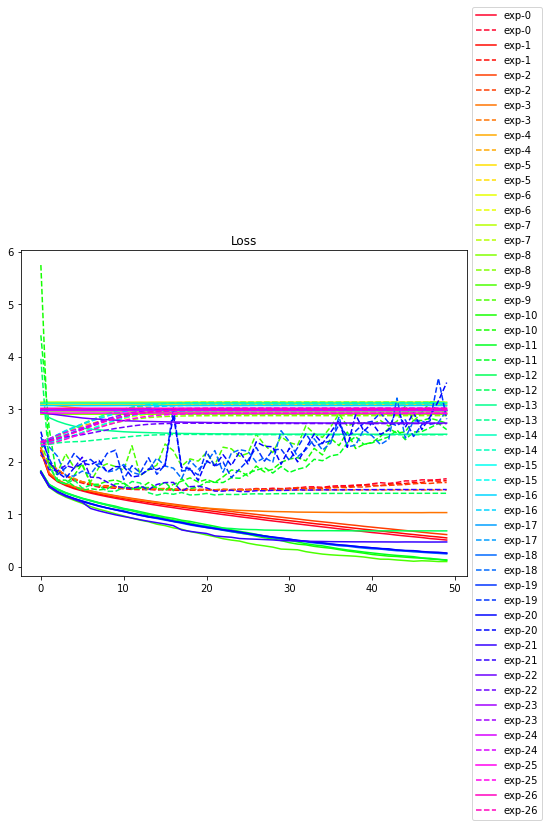

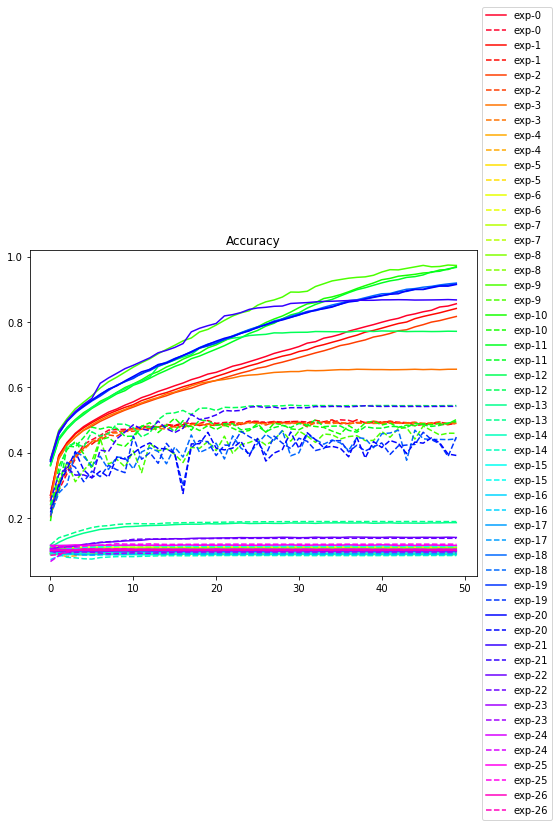

In [15]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()